# core

> lisette core

In [ ]:
#| default_exp core

In [ ]:
#| export
import litellm, json, asyncio
from typing import Optional
from html import escape
from litellm import acompletion, completion, stream_chunk_builder, ModelResponse, ModelResponseStream
from litellm.utils import function_to_dict
from toolslm.funccall import mk_ns, call_func, call_func_async, get_schema
from fastcore.utils import *

In [ ]:
from cachy import enable_cachy

In [ ]:
enable_cachy()

In [ ]:
from IPython.display import Markdown

## LiteLLM

Litellm provides an easy wrapper for most big LLM providers.

In [ ]:
ms = ["gemini/gemini-2.5-flash", "claude-sonnet-4-20250514", "openai/gpt-4.1"]

TODO: test mixed content/tool calls message (and mixed images too).

In [ ]:
#| export
@patch
def _repr_markdown_(self: litellm.ModelResponse):
    message = self.choices[0].message
    content = ''
    if message.content: content += message.content
    if message.tool_calls:
        tool_calls = [f"\n\n🔧 {tc.function.name}({tc.function.arguments})\n" for tc in message.tool_calls]
        content += "\n".join(tool_calls)
    if not content: content = str(message)
    details = [
        f"id: `{self.id}`",
        f"model: `{self.model}`",
        f"finish_reason: `{self.choices[0].finish_reason}`"
    ]
    if hasattr(self, 'usage') and self.usage: details.append(f"usage: `{self.usage}`")
    det_str = '\n- '.join(details)
    
    return f"""{content}

<details>

- {det_str}

</details>"""

In [ ]:
msg = [{'role':'user','content':'Hey there!', 'cache_control': {'type': 'ephemeral'}}]

In [ ]:
for m in ms:
    display(f'=== {m} ===')
    display(completion(m,msg))

'=== gemini/gemini-2.5-flash ==='

Hey there yourself! How can I help you today?

<details>

- id: `CpLKaOi_CoWekdUPgfC6qQo`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=113, prompt_tokens=4, total_tokens=117, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=102, rejected_prediction_tokens=None, text_tokens=11), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

'=== claude-sonnet-4-20250514 ==='

Hello! Nice to meet you! How are you doing today?

<details>

- id: `chatcmpl-81f2d807-331b-4c75-84d6-35d9d55f6b16`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=16, prompt_tokens=10, total_tokens=26, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

'=== openai/gpt-4.1 ==='

Hello! How can I help you today? 😊

<details>

- id: `chatcmpl-CGk0K97RqKKSH9PfLFacGXWcbnXBW`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=10, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Streaming

In [ ]:
#| export
def stream_with_complete(gen, postproc=noop):
    "Extend streaming response chunks with the complete response"
    chunks = []
    for chunk in gen:
        chunks.append(chunk)
        yield chunk
    postproc(chunks)
    return stream_chunk_builder(chunks)

In [ ]:
from fastcore.xtras import SaveReturn

In [ ]:
model = ms[1]

In [ ]:
r = completion(messages=msg, model=model, stream=True)
r2 = SaveReturn(stream_with_complete(r))

In [ ]:
for o in r2:
    cts = o.choices[0].delta.content
    if cts: print(cts, end='')

Hello! Nice to meet you. How are you doing today?

In [ ]:
r2.value

Hello! Nice to meet you. How are you doing today?

<details>

- id: `chatcmpl-26dcffb7-7c83-4e46-843a-d38dd20bf367`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=16, prompt_tokens=10, total_tokens=26, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

### Tools

In [ ]:
#| export
def _lite_mk_func(f):
    if isinstance(f, dict): return f
    return {'type':'function', 'function':get_schema(f, pname='parameters')}

In [ ]:
def simple_add(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Add two numbers together"
    print(f"TOOL CALLED {a=} + {b=}")
    return a + b

In [ ]:
toolsc = _lite_mk_func(simple_add)
toolsc

{'type': 'function',
 'function': {'name': 'simple_add',
  'description': 'Add two numbers together\n\nReturns:\n- type: integer',
  'parameters': {'type': 'object',
   'properties': {'a': {'type': 'integer', 'description': 'first operand'},
    'b': {'type': 'integer', 'description': 'second operand', 'default': 0}},
   'required': ['a']}}}

In [ ]:
#| export
def mk_user(s, cache=False):
    res = {"role": "user", "content": s}
    if cache: res['cache_control'] = {'type': 'ephemeral'}
    return res

In [ ]:
tmsg = mk_user("What is 5478954793+547982745? How about 5479749754+9875438979? Always use tools for calculations, and describe what you'll do before using a tool. Where multiple tool calls are required, do them in a single response where possible.")
r = completion(model, [tmsg], tools=[toolsc])

In [ ]:
r

I'll help you calculate both of those addition problems using the simple_add tool. Let me perform both calculations for you:

🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-71ef895b-0a25-4843-9304-d82493fd102d`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=160, prompt_tokens=475, total_tokens=635, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
#| export
def _lite_call_func(tc,ns,raise_on_err=True):
    res = call_func(tc.function.name, json.loads(tc.function.arguments),ns=ns)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": str(res)}

In [ ]:
tcs = [_lite_call_func(o, ns=globals()) for o in r.choices[0].message.tool_calls]
tcs

TOOL CALLED a=5478954793 + b=547982745
TOOL CALLED a=5479749754 + b=9875438979


[{'tool_call_id': 'toolu_013MZMqJL4fBRGTsMtAGJjMk',
  'role': 'tool',
  'name': 'simple_add',
  'content': '6026937538'},
 {'tool_call_id': 'toolu_01HkbM4zwAb38n4rH7SNvi75',
  'role': 'tool',
  'name': 'simple_add',
  'content': '15355188733'}]

In [ ]:
def delta_text(msg):
    "Extract printable content from streaming delta, return None if nothing to print"
    c = msg.choices[0]
    if not c: return c
    if not hasattr(c,'delta'): return None #f'{c}'
    delta = c.delta
    if delta.content: return delta.content
    if delta.tool_calls:
        res = ''.join(f"🔧 {tc.function.name}" for tc in delta.tool_calls if tc.id and tc.function.name)
        if res: return f'\n{res}\n'
    if hasattr(delta,'reasoning_content'): return '🧠' if delta.reasoning_content else '\n\n'
    return None

In [ ]:
r = completion(messages=[tmsg], model=model, stream=True, tools=[toolsc])
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

I'll help you calculate both of those sums using the addition tool. Let me perform both calculations for you:

1. First, I'll calculate 5478954793 + 547982745
2. Then, I'll calculate 5479749754 + 9875438979
🔧 simple_add

🔧 simple_add


In [ ]:
r2.value

I'll help you calculate both of those sums using the addition tool. Let me perform both calculations for you:

1. First, I'll calculate 5478954793 + 547982745
2. Then, I'll calculate 5479749754 + 9875438979

🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-d2456aec-a38d-4916-956f-6f7b5707b4a6`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=197, prompt_tokens=475, total_tokens=672, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
msg = mk_user("Solve this complex math problem: What is the derivative of x^3 + 2x^2 - 5x + 1?")
r = completion(messages=[msg], model=model, stream=True, reasoning_effort="low")
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')


🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

I'll find the derivative of f(x) = x³ + 2x² - 5x + 1 using the power rule.

The power rule states that for any term ax^n, the derivative is nax^(n-1).

Taking the derivative of each term:

**Term 1:** x³
- Derivative: 3x^(3-1) = 3x²

**Term 2:** 2x²  
- Derivative: 2 × 2x^(2-1) = 4x

**Term 3:** -5x
- Derivative: -5 × 1x^(1-1) = -5

**Term 4:** 1 (constant)
- Derivative: 0

**Final Answer:**
f'(x) = 3x² + 4x - 5

In [ ]:
r2.value

I'll find the derivative of f(x) = x³ + 2x² - 5x + 1 using the power rule.

The power rule states that for any term ax^n, the derivative is nax^(n-1).

Taking the derivative of each term:

**Term 1:** x³
- Derivative: 3x^(3-1) = 3x²

**Term 2:** 2x²  
- Derivative: 2 × 2x^(2-1) = 4x

**Term 3:** -5x
- Derivative: -5 × 1x^(1-1) = -5

**Term 4:** 1 (constant)
- Derivative: 0

**Final Answer:**
f'(x) = 3x² + 4x - 5

<details>

- id: `chatcmpl-07ba25f1-2b0b-4556-83dc-abe622910135`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=433, prompt_tokens=66, total_tokens=499, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=205, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
search_tool = { "type": "web_search_20250305", "name": "web_search", "max_uses": 3}
smsg = mk_user("Search the web and tell me very briefly about otters")
r = completion(ms[1], [smsg], tools=[search_tool])
r

Otters are carnivorous mammals in the weasel family, found on every continent except Australia and Antarctica. There are 13-14 species in total, ranging from the small-clawed otter to the giant otter.

Most are small, with short ears and noses, elongated bodies, long tails, and soft, dense fur. Otters have the densest fur of any animal—as many as a million hairs per square inch in places. Webbed feet and powerful tails, which act like rudders, make otters strong swimmers.

All otters are expert hunters that eat fish, crustaceans, and other critters. Sea otters have an ingenious method to open shellfish - they float on their back, place a rock on their chest, then smash the mollusk down on it until it breaks open. An otter's lung capacity is 2.5 times greater than that of similar-sized land mammals, with sea otters staying submerged for more than 5 minutes and river otters for up to 8 minutes.

They are playful animals, engaging in activities like sliding into water on natural slides and playing with stones. When it's time to nap, sea otters entangle themselves in kelp so they don't float away, and sometimes intertwine their feet with another sea otter.

<details>

- id: `chatcmpl-05552a7d-996c-4ce9-950e-fdbf583c6393`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=537, prompt_tokens=13316, total_tokens=13853, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), server_tool_use=ServerToolUse(web_search_requests=1), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

When not using streaming, all citations are placed in a separate key in the response:

In [ ]:
r.choices[0].message.provider_specific_fields['citations'][0]

[{'type': 'web_search_result_location',
  'cited_text': 'The charismatic otter, a member of the weasel family, is found on every continent except Australia and Antarctica. ',
  'url': 'https://www.nationalgeographic.com/animals/mammals/facts/otters-1',
  'title': 'Otters, facts and information | National Geographic',
  'encrypted_index': 'Eo8BCioIBxgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDEMAAKaklz1mIDpJ+BoMkjClqlQgJ+0SP5UPIjBCojeK7BKCrsJm2Gk75WoctlPZ7hVo6Huj2bxNInNAkVzBTc6Qi9xs58E5qnZ0hv4qE61tAl3XDgVXm5qB0eXYeh3lhnYYBA=='}]

In [ ]:
r = list(completion(ms[1], [smsg], tools=[search_tool], stream=True))

In [ ]:
#| export
def cite_footnote(msg):
    if not (delta:=nested_idx(msg, 'choices', 0, 'delta')): return
    if citation:= nested_idx(delta, 'provider_specific_fields', 'citation'):
        title = citation['title'].replace('"', '\\"')
        delta.content = f'[*]({citation["url"]} "{title}") '
        
def cite_footnotes(stream_list):
    "Add markdown footnote citations to stream deltas"
    for msg in stream_list: cite_footnote(msg)

In [ ]:
cite_footnotes(r)
stream_chunk_builder(r)

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters are charismatic members of the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 otter species in total, all semiaquatic and living in both freshwater and marine environments.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters have elongated bodies, short ears and noses, long tails, and powerful webbed feet that make them excellent swimmers. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") They have the densest fur of any animal—as many as a million hairs per square inch—which keeps them warm and waterproof.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") All otters are expert carnivorous hunters that eat fish, crustaceans, and other aquatic creatures. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters famously use rocks as tools, floating on their backs and smashing shellfish against stones placed on their chests. [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") They can hold their breath underwater for up to 8 minutes.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are notably playful animals, engaging in sliding, swimming games, and other recreational activities. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters even wrap themselves in kelp and sometimes hold hands while sleeping to avoid floating away.

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Many otter species were once hunted nearly to extinction for their fur and remain at risk from pollution and habitat loss today.

<details>

- id: `chatcmpl-6f3c995b-bfe4-4c00-915e-d91d3244d6ae`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=498, prompt_tokens=13316, total_tokens=13814, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

## Chat

Litellm is pretty bare bones. It doesnt keep track of conversation history or anything.

So lets make a claudette style wrapper so we can do streaming, toolcalling, and toolloops without problems.

In [ ]:
#| export
effort = AttrDict({o[0]:o for o in ('low','medium','high')})

In [ ]:
#| export
class Chat:
    def __init__(self, model:str, sp='', temp=0, tools:list=None, hist:list=None, ns:Optional[dict]=None, cache=False):
        "LiteLLM chat client."
        self.model = model
        hist,tools = listify(hist),listify(tools)
        if ns is None and tools: ns = mk_ns(tools)
        elif ns is None: ns = globals()
        self.tool_schemas = [_lite_mk_func(t) for t in tools] if tools else None
        store_attr()
    
    def _prepare_msgs(self, msg=None, prefill=None):
        "Prepare the messages list for the API call"
        msgs = [{"role": "system", "content": self.sp}] if self.sp else []
        self.hist += [mk_user(msg, cache=self.cache)] if isinstance(msg, str) \
            else [msg] if isinstance(msg, dict) \
            else [] if msg is None \
            else msg
        if prefill and get_model_info(self.model)["supports_assistant_prefill"]: 
            self.hist.append({"role":"assistant","content":prefill})
        return msgs + [m if isinstance(m, dict) else m.model_dump() for m in self.hist]

    def _call(self, msg=None, prefill=None, temp=None, think=None, stream=False, max_tool_rounds=1, tool_round=0, final_prompt=None, tool_choice=None, **kwargs):
        "Internal method that always yields responses"
        msgs = self._prepare_msgs(msg, prefill)
        res = completion(model=self.model, messages=msgs, stream=stream, 
                         tools=self.tool_schemas, reasoning_effort = effort.get(think),
                         # temperature is not supported when reasoning
                         temperature=None if think else (temp if temp is not None else self.temp), **kwargs)
        if stream: res = yield from stream_with_complete(res,postproc=cite_footnotes)
        m = res.choices[0].message
        self.hist.append(m)
        yield res

        if tcs := m.tool_calls:
            tool_results = [_lite_call_func(tc, ns=self.ns) for tc in tcs]
            for r in tool_results: yield r
            if tool_round>=max_tool_rounds-1:
                tool_results += ([{"role": "user", "content": final_prompt}] if final_prompt else [])
                tool_choice='none'
            yield from self._call(
                tool_results, prefill, temp, None, stream, max_tool_rounds, tool_round+1,
                final_prompt, tool_choice=tool_choice, **kwargs)
    
    def __call__(self, msg=None, prefill=None, temp=None, think=None, stream=False, max_tool_rounds=1,
                 final_prompt=None, return_all=False, **kwargs):
        "Main call method - handles streaming vs non-streaming"
        result_gen = self._call(msg, prefill, temp, think, stream, max_tool_rounds, 0, final_prompt, **kwargs)     
        if stream: return result_gen              # streaming
        elif return_all: return list(result_gen)  # toolloop behavior
        else: return last(result_gen)             # normal chat behavior

### Test history tracking

In [ ]:
chat = Chat(m)
res = chat("Hey my name is Rens")
res

Hi Rens! Nice to meet you. How can I help you today? 😊

<details>

- id: `chatcmpl-CGk10xbMMzVbMFK7bnGl8Xb0IzUFB`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=13, total_tokens=30, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

In [ ]:
chat("Whats my name")

Your name is Rens!

<details>

- id: `chatcmpl-CGk133yOT8QHuCSnENjZYzVXN3wIz`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=6, prompt_tokens=41, total_tokens=47, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See now we keep track of history!

### Testing streaming

In [ ]:
from time import sleep
chat2 = Chat(m)
stream_gen = chat2("Count to 5", stream=True)
for chunk in stream_gen:
    sleep(0.1)  # for effect
    if isinstance(chunk, ModelResponse): display(chunk)
    else: print(delta_text(chunk) or '',end='')

1  
2  
3  
4  
5

1  
2  
3  
4  
5

<details>

- id: `chatcmpl-CGk157EaClaUthJC8g6nh6XT4JQgz`
- model: `gpt-4.1`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=11, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

## Test tool use

Ok now lets test tool use

In [ ]:
for m in ms:
    display(f'=== {m} ===')
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3?")
    display(res)

'=== gemini/gemini-2.5-flash ==='

TOOL CALLED a=5 + b=3


5 + 3 = 8.


<details>

- id: `P5LKaJSbO6XYxs0P_4XAmAs`
- model: `gemini-2.5-flash`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=8, prompt_tokens=108, total_tokens=116, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=108, image_tokens=None))`

</details>

'=== claude-sonnet-4-20250514 ==='

TOOL CALLED a=5 + b=3


5 + 3 = 8

<details>

- id: `chatcmpl-86971ef0-4f90-4646-a131-8c1ab9e4d346`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=12, prompt_tokens=527, total_tokens=539, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

'=== openai/gpt-4.1 ==='

TOOL CALLED a=5 + b=3


5 + 3 equals 8.

<details>

- id: `chatcmpl-CGk1F5X8YRwN09Bks4bJOSGnmYxka`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=101, total_tokens=110, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

In [ ]:
chat = Chat(ms[1], tools=[search_tool])
res = chat("Search the web and tell me very briefly about otters", stream=True)
for o in res:
    if isinstance(o, ModelResponse): sleep(0.01); display(o)
    else: print(delta_text(o) or '',end='')

Otters are carnivorous mammals in the weasel family, found on every continent except Australia and Antarctica. There are 13-14 species in total, ranging from the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These aquatic mammals have elongated bodies, long tails, and soft, dense fur, with the densest fur of any animal—as many as a million hairs per square inch. Their most striking features are powerful webbed feet for swimming and seal-like breath-holding abilities.

Otters are expert hunters that eat fish, crustaceans, and other critters. Sea otters use tools, floating on their backs and smashing mollusks on rocks placed on their chests. River otters can hold their breath for up to 8 minutes, while sea otters stay submerged for over 5 minutes.

Known for being playful animals that slide into water and gambol on land, otters are also highly social. Sea otters entangle themselves in kelp to avoid floating away while sleeping and sometimes hold hands w

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") carnivorous mammals in the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur, with [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") the densest fur of any animal—as many as a million hairs per square inch. [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Their most striking features are powerful webbed feet for swimming and seal-like breath-holding abilities.

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters use tools, floating on their backs and smashing mollusks on rocks placed on their chests. [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") River otters can hold their breath for up to 8 minutes, while sea otters stay submerged for over 5 minutes.

Known for being [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") playful animals that slide into water and gambol on land, otters are also highly social. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters entangle themselves in kelp to avoid floating away while sleeping and sometimes hold hands with other otters.

Unfortunately, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") many otter species were hunted extensively for their fur and remain at risk from pollution and habitat loss, with [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") sea otters listed as endangered.

<details>

- id: `chatcmpl-fb79af83-47f8-43c6-806b-13a6298888d5`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=566, prompt_tokens=13316, total_tokens=13882, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None), prompt_tokens_details=None)`

</details>

## Test multi tool calling

In [ ]:
chat = Chat(model, tools=[simple_add])
res = chat("What's ((5 + 3)+7)+11? Work step by step", return_all=True, max_tool_rounds=5)
for r in res: display(r)

TOOL CALLED a=5 + b=3
TOOL CALLED a=8 + b=7
TOOL CALLED a=15 + b=11


I'll solve this step by step using the addition function.

First, let me calculate 5 + 3:

🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-4510de8b-933a-45de-838c-2534f8511445`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=96, prompt_tokens=434, total_tokens=530, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01PbJNpks9G6o9UYjRs5nd4b',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

Now I'll add 7 to that result (8 + 7):

🔧 simple_add({"a": 8, "b": 7})


<details>

- id: `chatcmpl-cf73f88a-bb37-4cf9-abfb-d2ce22be724f`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=88, prompt_tokens=543, total_tokens=631, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01PAuvDwaBNgM2JbEwJwxov5',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

Finally, I'll add 11 to that result (15 + 11):

🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-dc6a183f-03ff-4d07-a66e-34b8db215ba9`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=89, prompt_tokens=644, total_tokens=733, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01KeELPbBSpCePrk4c8EzbyB',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

So working step by step:
- 5 + 3 = 8
- 8 + 7 = 15  
- 15 + 11 = 26

Therefore, ((5 + 3) + 7) + 11 = **26**

<details>

- id: `chatcmpl-ea8419ef-e351-438a-a2d9-db2723ee732b`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=68, prompt_tokens=746, total_tokens=814, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
@patch(as_prop=True)
def cost(self: Chat):
    "Total cost of all responses in conversation history"
    return sum(getattr(r, '_hidden_params', {}).get('response_cost')  or 0
               for r in self.h if hasattr(r, 'choices'))

Some models support parallel tool calling. I.e. sending multiple tool call requests in one conversation step.

In [ ]:
def multiply(a: int, b: int) -> int:
    "Multiply two numbers"
    print(f"MULTIPLY: {a} * {b}")
    return a * b

chat = Chat(ms[-1], tools=[simple_add, multiply])
res = chat("Calculate (5 + 3) * (7 + 2)", max_tool_rounds=5, return_all=True)
for r in res: display(r)

TOOL CALLED a=5 + b=3
TOOL CALLED a=7 + b=2
MULTIPLY: 8 * 9




🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-CGk1fLa7VA3Mc1PAqP3EC8cWeAYmI`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=110, total_tokens=162, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_8ZH9yZH3N9TEmaIOmV6H81mU',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_uDxT76wyUI8WY9ugRPwCnlb9',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a":8,"b":9})


<details>

- id: `chatcmpl-CGk1gcySPBO2WLk2NP0OmV6CmuWZ9`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=178, total_tokens=195, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_Dm0jjJPQf2elRy4z7yBhOMf5',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) = 8 and (7 + 2) = 9. Multiplying them together: 8 × 9 = 72. 

So, (5 + 3) * (7 + 2) = 72.

<details>

- id: `chatcmpl-CGk1htUXKeYdDxJf9BYj6ZfgbEw6l`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=55, prompt_tokens=203, total_tokens=258, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See it did the additions in one go!

Hit max_tool_rounds limit with final_prompt

In [ ]:
def divide(a: int, b: int) -> float:
    "Divide two numbers"
    display(f"DIVIDE: {a} / {b}")
    return a / b

chat = Chat(model, tools=[simple_add, multiply, divide])
res = chat("Calculate ((10 + 5) * 3) / (2 + 1) step by step", 
           max_tool_rounds=2, return_all=True,
           final_prompt="Please summarize what you've calculated so far")
print(f"Got {len(res)} responses")
for r in res: display(r)

TOOL CALLED a=10 + b=5
TOOL CALLED a=2 + b=1
Got 5 responses


I'll calculate this step by step using the available functions, following the order of operations (parentheses first, then multiplication/division from left to right).

Step 1: Calculate (10 + 5)

🔧 simple_add({"a": 10, "b": 5})


<details>

- id: `chatcmpl-8c5ac183-7591-4782-abeb-c41c4f5e65b4`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=116, prompt_tokens=608, total_tokens=724, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01TsmBSiBevYHvSfCUirXFcY',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

Step 2: Calculate (2 + 1)

🔧 simple_add({"a": 2, "b": 1})


<details>

- id: `chatcmpl-97d855c5-f439-4df8-ad2f-75c3c970721e`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=83, prompt_tokens=737, total_tokens=820, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01HBq2SEjPxuG6JxXiduEca7',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}

So far, I've calculated the expressions inside the parentheses:

**Step 1:** (10 + 5) = 15
**Step 2:** (2 + 1) = 3

Now the expression becomes: (15 * 3) / 3

Next, I need to:
- Step 3: Multiply 15 * 3
- Step 4: Divide that result by 3

Would you like me to continue with the remaining steps?

<details>

- id: `chatcmpl-346729d4-4b1f-4e30-a08b-8122bf922aba`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=111, prompt_tokens=847, total_tokens=958, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

## Async

In [ ]:
#| export
async def _alite_call_func(tc, ns, raise_on_err=True):
    res = await call_func_async(tc.function.name, json.loads(tc.function.arguments), ns=ns)
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": str(res)}

As you cannot receive the return value of an async generator we have to write a little wrapper to capture this result:

In [ ]:
#| export
@asave_iter
async def astream_result(self, agen, postproc=noop):
    chunks = []
    async for chunk in agen:
        chunks.append(chunk)
        postproc(chunk)
        yield chunk
    self.value = stream_chunk_builder(chunks)

AsyncChat follows the same implementation as Chat as much as possible:

In [ ]:
#| export
class AsyncChat(Chat):
    async def _call(self, msg=None, prefill=None, temp=None, think=None, stream=False, max_tool_rounds=1, tool_round=0, final_prompt=None, tool_choice=None, **kwargs):
        msgs = self._prepare_msgs(msg, prefill)
        res = await acompletion(model=self.model, messages=msgs, stream=stream,
                         tools=self.tool_schemas, reasoning_effort=effort.get(think), 
                         # temperature is not supported when reasoning
                         temperature=None if think else (temp if temp is not None else self.temp), 
                         **kwargs)
        if stream:
            res = astream_result(res,postproc=cite_footnote)
            async for chunk in res: yield chunk
            res = res.value
        
        yield res
        self.hist.append(m:=res.choices[0].message)

        if tcs := m.tool_calls:
            tool_results = []
            for tc in tcs:
                result = await _alite_call_func(tc, ns=self.ns)
                tool_results.append(result)
                yield result
            
            if tool_round>=max_tool_rounds-1:
                tool_results += ([{"role": "user", "content": final_prompt}] if final_prompt else [])
                tool_choice='none'
            
            async for result in self._call(
                tool_results, prefill, temp, None, stream, max_tool_rounds, tool_round+1,
                final_prompt, tool_choice=tool_choice, **kwargs):
                    yield result
    
    async def __call__(self, msg=None, prefill=None, temp=None, think=None, stream=False, max_tool_rounds=1, final_prompt=None, return_all=False, **kwargs):
        result_gen = self._call(msg, prefill, temp, think, stream, max_tool_rounds, 0, final_prompt, **kwargs)
        if stream or return_all: return result_gen
        async for res in result_gen: pass
        return res # normal chat behavior only return last msg

Basic example

In [ ]:
chat = AsyncChat(model="claude-sonnet-4-20250514")
await chat("What is 2+2?")

2 + 2 = 4

<details>

- id: `chatcmpl-f11d0f78-afcd-451e-b9f5-f83754a9f2ec`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=13, prompt_tokens=14, total_tokens=27, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

With tool calls

In [ ]:
async def async_add(a: int, b: int) -> int:
    "Add two numbers asynchronously"
    await asyncio.sleep(0.1)
    return a + b

In [ ]:
chat_with_tools = AsyncChat(model="claude-sonnet-4-20250514", tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", return_all=True)
async for r in res: display(r)

I'll use the async_add tool to calculate 5 + 7 for you.

🔧 async_add({"a": 5, "b": 7})


<details>

- id: `chatcmpl-d2ae7f67-a410-439c-aa01-e2d2b286375b`
- model: `claude-sonnet-4-20250514`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=91, prompt_tokens=424, total_tokens=515, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_01X1GDcGawNLq77xytxEGDBw',
 'role': 'tool',
 'name': 'async_add',
 'content': '12'}

The result of 5 + 7 is 12.

<details>

- id: `chatcmpl-21c83275-ee46-4efe-9c2e-3fad0b9ed1da`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=528, total_tokens=545, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

With streaming:

In [ ]:
chat_with_tools = AsyncChat(model="claude-sonnet-4-20250514", tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", stream=True)
async for o in res: 
    if isinstance(o,ModelResponseStream): print(delta_text(o) or '',end='')
    elif isinstance(o,dict): print(o)

I'll use the async_add tool to calculate 5 + 7 for you.
🔧 async_add
{'tool_call_id': 'toolu_01NTrwnCZYd6K7ZeNQtUyx9k', 'role': 'tool', 'name': 'async_add', 'content': '12'}
The result of 5 + 7 is 12.

Lets improve display for async streaming:

In [ ]:
#| export
def _clean_str(text):
    "Clean content to prevent breaking surrounding markdown formatting."
    return escape(str(text)).replace('`', '').replace('\n', ' ').replace('|', ' ')

In [ ]:
#| export
def _trunc_str(s, mx=2000, replace="…"):
    "Truncate `s` to `mx` chars max, adding `replace` if truncated"
    s = str(s).strip()
    return s[:mx]+replace if len(s)>mx else s

In [ ]:
#| export
async def aformat_stream(rs):
    "Format the response stream for markdown display."
    think = False
    async for o in rs:
        if isinstance(o, ModelResponseStream):
            d = o.choices[0].delta
            if nested_idx(d, 'reasoning_content'): 
                think = True
                yield '🧠'
            elif think:
                think = False
                yield '\n\n'
            if c := d.content: yield c
        elif isinstance(o, ModelResponse) and (c := getattr(o.choices[0].message, 'tool_calls', None)):
            fn = first(c).function
            yield f"\n<details class='tool-usage-details'>\n\n `{fn.name}({_trunc_str(fn.arguments)})`\n"
        elif isinstance(o, dict) and 'tool_call_id' in o: 
            yield f"  - `{_trunc_str(_clean_str(o.get('content')))}`\n\n</details>\n\n"

In [ ]:
#| export
async def adisplay_stream(rs):
    "Use IPython.display to markdown display the response stream."
    md = ''
    async for o in aformat_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)

And demonstrate it with a toolcall

In [ ]:
chat = AsyncChat(model="claude-sonnet-4-20250514", tools=[async_add])
res = await chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
await adisplay_stream(res)

I'll use the async_add tool to calculate 5 + 7 for you.
<details class='tool-usage-details'>

 `async_add({"a": 5, "b": 7})`
  - `12`

</details>

The result of 5 + 7 is 12.

With thinking:

In [ ]:
chat = AsyncChat(model="claude-sonnet-4-20250514")
res = await chat("What's the most efficient way to sort a list of 1000 random integers?", think='l',stream=True)
await adisplay_stream(res)

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

For sorting 1000 random integers, the most efficient approach is typically to **use your programming language's built-in sort function**. Here's why:

## Best Practical Choice: Built-in Sort
```python
# Python
numbers.sort()  # or sorted(numbers)

# JavaScript  
numbers.sort((a, b) => a - b)

# C++
std::sort(numbers.begin(), numbers.end())

# Java
Arrays.sort(numbers)
```

## Why Built-in Sorts Are Best:

1. **Highly optimized implementations** - Usually hybrid algorithms like:
   - **Timsort** (Python, Java) - O(n log n), optimized for real-world data
   - **Introsort** (C++) - Combines quicksort, heapsort, and insertion sort

2. **Adaptive performance** - Perform better on partially sorted data

3. **Well-tested and debugged**

## For Educational/Custom Implementation:

If you need to implement your own, **Quicksort** is often the best choice for random data:

```python
def quicksort(arr, low, high):
    if low < high:
        pi = partition(arr, low, high)
   

And websearch:

In [ ]:
chat_stream_tools = AsyncChat(model="claude-sonnet-4-20250514", tools=[search_tool])
res = await chat_stream_tools("Search the web and tell me very briefly about otters", stream=True)
await adisplay_stream(res)

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") carnivorous mammals in the weasel family, found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 13-14 species in total, ranging from [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") the Asian small-clawed otter (smallest) to the giant otter and sea otter (largest).

These aquatic mammals have [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") elongated bodies, long tails, and soft, dense fur, with [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") the densest fur of any animal—as many as a million hairs per square inch. [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Their most striking features are powerful webbed feet for swimming and seal-like breath-holding abilities.

Otters are [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters use tools, floating on their backs and smashing mollusks on rocks placed on their chests. [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") [*](https://www.pbs.org/wnet/nature/blog/otter-fact-sheet/ "Otter Fact Sheet | Blog | Nature | PBS") River otters can hold their breath for up to 8 minutes, while sea otters stay submerged for over 5 minutes.

Known for being [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") playful animals that slide into water and gambol on land, otters are also highly social. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters entangle themselves in kelp to avoid floating away while sleeping and sometimes hold hands with other otters.

Unfortunately, [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") many otter species were hunted extensively for their fur and remain at risk from pollution and habitat loss, with [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") sea otters listed as endangered.

## Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
from IPython.display import Image

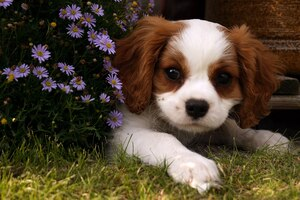

In [ ]:
fn = Path('samples/puppy.jpg')
Image(filename=fn, width=200)

In [ ]:
def _mk_img(data:bytes)->tuple:
    "Convert image bytes to a base64 encoded image"
    img = base64.b64encode(data).decode("utf-8")
    mtype = mimetypes.types_map["."+imghdr.what(None, h=data)]
    return img, mtype

In [ ]:
import base64
import mimetypes
from fastcore import imghdr

In [ ]:
imgbytes = fn.read_bytes()
img,mtype = _mk_img(imgbytes)
imgd = { "image_url": {"url": f'data:{mtype};base64,{img}', "format":mtype} }

In [ ]:
response = completion( model=model, 
    messages=[
        { "role": "user",
        "content": [{ "type": "text", "text": "What’s in this image?" },
        { "type": "image_url", **imgd }] }
    ])

In [ ]:
response

This adorable image shows a young puppy, likely a Cavalier King Charles Spaniel or similar breed, with beautiful reddish-brown and white fur markings. The puppy has distinctive coloring with brown patches around the ears and eyes, and a white blaze down the face and chest. The puppy is positioned near some lovely purple flowers (they appear to be asters or a similar daisy-like flower) and is sitting on grass. The setting appears to be outdoors in a garden area, and the puppy has that sweet, innocent expression that's so characteristic of young dogs. The lighting and composition give the photo a warm, natural feel.

<details>

- id: `chatcmpl-906e5944-ddde-4808-a535-1b1c77d7d1a7`
- model: `claude-sonnet-4-20250514`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=142, prompt_tokens=104, total_tokens=246, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>